# 5. CNN을 이용한 분류 (CIFAR10)

합성곱 신경망(Convolutional Neural Network)를 이용한 이미지 분류

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## 5.1 CIFAR10 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd/content/drive/MyDrive/Colab_Notebooks/deeplearningbro/pytorch

/content/drive/MyDrive/Colab_Notebooks/deeplearningbro/pytorch


In [4]:
# CIFAR10: 클래스 10개를 가진 이미지 데이터
# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 0,1,2 각각의 채널에 mean과 std를 곱해서 정규화

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True) # 데이터를 배치 형태로 만들기

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# CPU or GPU :: 연산 종류 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


## 5.2 CNN 모델 구축

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 합성곱 연산 (입력 채널수 3, 출력 채널수 6, 필터크기 5x5 , stride=1(defualt))
        self.pool1 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5) # 합성곱 연산 (입력 채널수 6, 출력 채널수 16, 필터크기 5x5 , stride=1(defualt))
        self.pool2 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5x5 피쳐맵 16개를 일렬로 피면 16*5*5개의 노드가 생성
        self.fc2 = nn.Linear(120, 10) # 120개 노드에서 클래스의 개수인 10개의 노드로 연산

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) # conv1 -> ReLU -> pool1
        x = self.pool2(F.relu(self.conv2(x))) # conv2 -> ReLU -> pool2
        x = x.view(-1, 16 * 5 * 5) # 5x5 피쳐맵 16개를 일렬로 만든다. // 여기서 -1은 배치 수 .
        # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)

        return x

net = Net().to(device) # 모델 선언


In [7]:
print(net)
# 피쳐의 크기: 32 -> 28 ->14 -> 10 -> 5

'''
16 * 5 * 5 ::
너비 높이가 같은 입력 이미지를 사용할 경우 피쳐맵의 가로 세로 크기는 일반적으로 다음과 같이 계산 됩니다. 

output size = 1 + (input size + 2*padding - filter size)/stride

따라서 각 층을 위 식과 필터 개수를 같이 고려하여 계산하면 다음과 같은 결과를 얻게 됩니다.

입력 이미지 크기 3x32x32

conv1의 피쳐맵 크기 1+(32-5)/1=28 -> 6x28x28

pool1의 피쳐맵 크기 1+(28-2)/2=14 -> 6x14x14

conv2의 피쳐맵 크기 1+(14-5)/1=10 -> 16x10x10

pool2의 피쳐맵 크기 1+(10-2)/2=5 -> 16x5x5

'''

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


## 5.3 모델 학습하기

In [8]:

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [9]:
# 모델의 학습 과정인 4강에서 배운 인공 신경망과 동일하다.
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader) # 배치 개수

for epoch in range(10):  # 10번 학습을 진행한다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 GPU용 :: GPU 계산이 가능한 Tensor로 만들어줌.
        
        optimizer.zero_grad()

        outputs = net(inputs) # 예측값 산출 :: 이미지 받아서 10개짜리 노드 산출
        loss = criterion(outputs, labels) # 손실함수(Cross Entropy) 계산 :: 여기서  label은 0~9 로 숫자 하나 값 / outputs : node가 10개인 vector
        '''
        파이토치에서 크로스 엔트로피에 해당하는 criterion(A, B)에서  A의 크기를 (배치 크기)x(클래스 수), B의 크기를 (배치 크기)로 입력 받도록 정의하였습니다. 
        즉, 입력 형식을 맞춰 주셔야만 사용이 가능하다는 말입니다. 생각하고 계신 계산 과정은 내부에서 자동으로 처리해 주는 것이므로 걱정 안 하셔도 되요 :)
        '''
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        # 배치마다 계산이 되는 거기 때문에 배치마다의 loss를 더해서
        running_loss += loss.item()

    loss_.append(running_loss / n)  # 평균 loss로 epoch 1개당의 loss
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))

print('Finished Training')

[1] loss: 1.749
[2] loss: 1.335
[3] loss: 1.183
[4] loss: 1.085
[5] loss: 1.014
[6] loss: 0.958
[7] loss: 0.909
[8] loss: 0.869
[9] loss: 0.833
[10] loss: 0.798
Finished Training


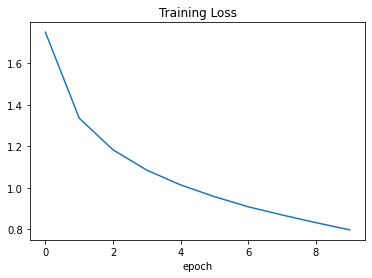

In [10]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 5.4 모델 저장하기

In [12]:
PATH = './models/cifar_net.pth' # 모델 저장 경로 
torch.save(net.state_dict(), PATH) # 모델(의 파라미터) 저장

## 5.5 모델 불러오기

In [13]:
# 위에서 GPU 용으로 모델 파라미터를 계산했으므로 모델 파라미터를 받을 모델의 뼈대도 GPU용으로 만들고 GPU로 계산해야 함.
# 모델 불러오기는 엄밀히 말하자면 "모델의 파라메타"를 불러오는 것이다. <<따라서 모델의 뼈대를 먼저 선언>>하고
# 모델의 파라메타를 불러와 pretrained model을 만든다.

net = Net().to(device) # 모델 선언
net.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

## 5.6 모델 정확도(Accuracy) 구하기

In [14]:
# 모델 정확도는 Update가 되지 않기 때문에 with torch.no_grad() 구문 안에
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


In [ ]:
# _, predicted = torch.max(outputs.data, 1)의 의미
'''
outputs의 크기가 (배치 크기)x(클래스의 개수)이므로  열이 하나의 이미지의 대응되는 벡터를 나타냅니다. 따라서 행(0), 열(1) 중 열을 기준으로 최댓값을 뽑아 예측값을 하나 만드는 것입니다. 

예를 들어서 배치 크기가 2이고 클래스가 3개인 outputs가 있다고 생각해봅니다.

outputs = [[0.1, 0.4, 0.5], [0.2, 0.6, 0,2]] 

여기서의 최댓값의 위치는 2번째(0.5)와 1번째(0.6)입니다. 즉, 첫번째 이미지는 2라고 예측하는 것이고 두번째 이미지는 1이라고 예측을 하게 됩니다. 이를 torch.max를 이용하여 나타냅니다.

torch.max는 최댓값과 최댓값의 위치를 산출해주는데 여기서 우리는 최댓값은 필요가 없으므로 받지 않아도 됩니다.

따라서 _ (언더바)로 처리하여 해당 출력값은 저장하지 않겠다는 의미입니다. 즉, _, predicted는 최댓값의 위치만 predicted에 저장하겠다는 의미입니다.

따라서 _, predicted = torch.max(outputs.data, 1)의 의미는 각 열(1)마다 최댓값의 위치를 예측값으로 사용하겠다는 의미입니다. 

마지막으로 .data는 예측값을 계산할 때는 역전파 계산이 필요없기 때문에 데이터만 사용한다는 의미에서 사용된 것입니다. 

( 그런데 지금 보니까 with torch.no_grad()를 사용했기 때문에 .data를 없애도 될 것 같습니다.)

'''